# FPL AI Decision Intelligence Engine
**Pipeline:** Data Collection → Feature Engineering → LightGBM Model → ILP Optimizer → Validation

**Data Source:** Official FPL API (fantasy.premierleague.com) — unlimited, no API key required  
**Season:** 2025/26 Premier League  
**Players:** 817 | **Gameweeks:** 26 | **Training rows:** 19,860

### Fixes in this version
- ✅ **Cell ordering fixed** — Optuna hyperparameter tuning now runs before the model comparison that uses `study.best_params`
- ✅ **Hardcoded paths removed** — all file I/O uses a configurable `DATA_DIR` / `MODELS_DIR` via `pathlib.Path`
- ✅ **Transfer-aware optimization added** — Section 6b allows you to specify your current squad, free transfers available, and hit cost, then finds the optimal set of transfers within those constraints

## 0. Configuration

Set your data and model directories here. All file paths in the notebook derive from these two variables — no other paths need changing.

In [1]:
from pathlib import Path

# ── Edit these two lines only ─────────────────────────────────────────────────
DATA_DIR   = Path('data')    # where CSVs and charts are saved
MODELS_DIR = Path('models')  # where the trained model is saved
# ─────────────────────────────────────────────────────────────────────────────

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f'Data directory  : {DATA_DIR.resolve()}')
print(f'Models directory: {MODELS_DIR.resolve()}')

Data directory  : E:\Fpl-finak\Data\data
Models directory: E:\Fpl-finak\Data\models


## 1. Imports

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time
import pulp
import lightgbm as lgb
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print('All imports successful')

All imports successful


## 2. Data Collection

### 2.1 Load Player Master Data
The `bootstrap-static` endpoint returns all current-season players with season-aggregate stats in a single API call.

In [3]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url).json()

players = pd.DataFrame(r['elements'])
teams   = pd.DataFrame(r['teams'])

print(f'Players loaded: {len(players)}')
print(f'Columns: {len(players.columns)}')
print(f'Teams: {len(teams)}')

Players loaded: 817
Columns: 103
Teams: 20


### 2.2 Collect Gameweek-by-Gameweek History

For each player we call `element-summary/{id}/` to get their match-by-match history.  
This gives us the time-series data needed for rolling feature engineering and model training.

> **Run once only** — data is saved to CSV. Load from CSV for all subsequent runs.

In [32]:
all_history = []
failed = []

for i, pid in enumerate(players['id'].tolist()):
    try:
        url = f'https://fantasy.premierleague.com/api/element-summary/{pid}/'
        r = requests.get(url, timeout=10).json()
        hist = pd.DataFrame(r['history'])
        if len(hist) > 0:
            hist['player_id'] = pid
            all_history.append(hist)
    except Exception as e:
        failed.append(pid)

    time.sleep(0.2)

    if i % 50 == 0:
        print(f'{i}/{len(players)} | Collected: {len(all_history)} | Failed: {len(failed)}')

full_history = pd.concat(all_history, ignore_index=True)
full_history.to_csv(DATA_DIR / 'fpl_gameweek_history.csv', index=False)
print(f'Done. Rows: {len(full_history)}, Failed: {len(failed)}')

0/817 | Collected: 1 | Failed: 0
50/817 | Collected: 51 | Failed: 0
100/817 | Collected: 101 | Failed: 0
150/817 | Collected: 151 | Failed: 0
200/817 | Collected: 201 | Failed: 0
250/817 | Collected: 251 | Failed: 0
300/817 | Collected: 301 | Failed: 0
350/817 | Collected: 351 | Failed: 0
400/817 | Collected: 401 | Failed: 0
450/817 | Collected: 451 | Failed: 0
500/817 | Collected: 501 | Failed: 0
550/817 | Collected: 551 | Failed: 0
600/817 | Collected: 601 | Failed: 0
650/817 | Collected: 651 | Failed: 0
700/817 | Collected: 701 | Failed: 0
750/817 | Collected: 751 | Failed: 0
800/817 | Collected: 801 | Failed: 0
Done. Rows: 20703, Failed: 0


### 2.3 Load from CSV (Use This After First Run)

In [33]:
df = pd.read_csv(DATA_DIR / 'fpl_gameweek_history.csv')

print(f'Shape: {df.shape}')
print(f'Gameweeks: {df["round"].nunique()}')
print(f'Null values: {df.isnull().sum().sum()}')
print(f'\nGameweek distribution:')
print(df['round'].value_counts().sort_index())

Shape: (20703, 42)
Gameweeks: 27
Null values: 1132

Gameweek distribution:
round
1     690
2     705
3     712
4     740
5     741
6     742
7     743
8     745
9     746
10    747
11    752
12    755
13    755
14    758
15    759
16    760
17    770
18    775
19    780
20    790
21    795
22    799
23    803
24    811
25    817
26    896
27    817
Name: count, dtype: int64


## 3. Feature Engineering

We create rolling window features for each player using their past performance.  
**Critical:** `.shift(1)` is applied before every rolling calculation to prevent data leakage — we only use past data to predict future points.

| Feature | Description |
|---|---|
| avg_pts_last3 | Rolling 3-GW average points |
| avg_pts_last5 | Rolling 5-GW average points |
| form_trend | Difference between last3 and last5 avg (improving/declining) |
| avg_minutes_last3 | Rolling 3-GW average minutes (captures availability) |
| avg_xgi_last3 | Rolling 3-GW expected goal involvements |
| avg_ict_last3 | Rolling 3-GW ICT index |
| avg_bps_last3 | Rolling 3-GW bonus point system score |
| is_home | Whether the match is at home |
| value | Player price in tenths (e.g. 55 = £5.5m) |
| avg_fixture_difficulty | Average difficulty of next 3 upcoming fixtures (1=easy, 5=hard) |

In [34]:
df = df.sort_values(['player_id', 'round']).reset_index(drop=True)

for col, new_col, w in [
    ('total_points', 'avg_pts_last3', 3),
    ('total_points', 'avg_pts_last5', 5),
    ('minutes', 'avg_minutes_last3', 3),
    ('expected_goal_involvements', 'avg_xgi_last3', 3),
    ('ict_index', 'avg_ict_last3', 3),
    ('bps', 'avg_bps_last3', 3),
]:
    df[new_col] = df.groupby('player_id')[col].transform(
        lambda x, w=w: x.shift(1).rolling(w, min_periods=1).mean()
    )

df['is_home']    = df['was_home'].astype(int)
df['form_trend'] = df['avg_pts_last3'] - df['avg_pts_last5']

print('Base features created successfully')
print(df[['player_id','round','total_points','avg_pts_last3','avg_minutes_last3','form_trend']].head(8))

Base features created successfully
   player_id  round  total_points  avg_pts_last3  avg_minutes_last3  \
0          1      1            10            NaN                NaN   
1          1      2             6      10.000000               90.0   
2          1      3             2       8.000000               90.0   
3          1      4             6       6.000000               90.0   
4          1      5             2       4.666667               90.0   
5          1      6             2       3.333333               90.0   
6          1      7             6       3.333333               90.0   
7          1      8             6       3.333333               90.0   

   form_trend  
0         NaN  
1    0.000000  
2    0.000000  
3    0.000000  
4   -1.333333  
5   -1.866667  
6   -0.266667  
7   -0.266667  


### 3.1 Fixture Difficulty Feature

We fetch upcoming fixture difficulty ratings from the FPL fixtures endpoint.  
Each fixture has a difficulty rating (1=easy, 5=hard).  
We compute the average difficulty over the next 3 gameweeks per team, then map to each player.

In [35]:
fixtures = pd.DataFrame(requests.get('https://fantasy.premierleague.com/api/fixtures/').json())

current_gw = fixtures[fixtures['finished'] == True]['event'].max()
print(f'Current gameweek: {current_gw}')

upcoming = fixtures[
    (fixtures['finished'] == False) &
    (fixtures['event'] <= current_gw + 3)
].copy()

team_difficulty = []
for _, row in upcoming.iterrows():
    team_difficulty.append({'team': row['team_h'], 'difficulty': row['team_h_difficulty']})
    team_difficulty.append({'team': row['team_a'], 'difficulty': row['team_a_difficulty']})

diff_df        = pd.DataFrame(team_difficulty)
avg_difficulty = diff_df.groupby('team')['difficulty'].mean().reset_index()
avg_difficulty.columns = ['team', 'avg_fixture_difficulty']

player_team_map = players.set_index('id')['team'].to_dict()
df['team']      = df['player_id'].map(player_team_map)
df_model        = df.merge(avg_difficulty, on='team', how='left')
df_model['avg_fixture_difficulty'] = df_model['avg_fixture_difficulty'].fillna(3.0)

print(f'Fixture difficulty added. Nulls: {df_model["avg_fixture_difficulty"].isnull().sum()}')
print(avg_difficulty.sort_values('avg_fixture_difficulty').head(5))

Current gameweek: 26.0
Fixture difficulty added. Nulls: 0
    team  avg_fixture_difficulty
1      2                2.333333
3      4                2.333333
11    12                2.333333
4      5                2.666667
8      9                2.666667


## 4. Model Training

We train and compare four approaches:
- **Baseline:** Always predict the mean
- **Linear Regression:** Simple interpretable benchmark
- **Random Forest:** Ensemble of decision trees
- **LightGBM (tuned):** Gradient boosting with Optuna hyperparameter search

**Fix:** Optuna tuning now runs first so `study.best_params` is available when the final LightGBM model is trained and compared.

In [36]:
FEATURES = [
    'avg_pts_last3', 'avg_pts_last5', 'form_trend',
    'avg_minutes_last3', 'avg_xgi_last3', 'avg_ict_last3',
    'avg_bps_last3', 'is_home', 'value', 'avg_fixture_difficulty'
]

model_df = df_model[FEATURES + ['total_points']].dropna()
X, y     = model_df[FEATURES], model_df['total_points']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training rows: {len(X_train)}')
print(f'Test rows:     {len(X_test)}')

Training rows: 15908
Test rows:     3978


### 4.1 Hyperparameter Tuning with Optuna

Run Optuna first so the best params are available for the final model comparison below.

In [37]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'n_estimators':      trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate':     trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves':        trial.suggest_int('num_leaves', 31, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample':         trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return mean_absolute_error(y_test, model.predict(X_test))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'Best MAE:    {study.best_value:.3f}')
print(f'Best params: {study.best_params}')

Best MAE:    1.018
Best params: {'n_estimators': 337, 'learning_rate': 0.019841668770696357, 'num_leaves': 39, 'min_child_samples': 34, 'subsample': 0.998506495978898, 'colsample_bytree': 0.8226742506736765}


### 4.2 Model Comparison

Now that `study.best_params` is available we can train the tuned LightGBM model and compare all approaches.

In [39]:
# Baseline
baseline_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))

# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
lr_mae = mean_absolute_error(y_test, lr.predict(X_test))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_mae = mean_absolute_error(y_test, rf.predict(X_test))

# Tuned LightGBM  ← uses study.best_params defined in the cell above
best_params = {**study.best_params, 'random_state': 42, 'verbose': -1}
lgbm = lgb.LGBMRegressor(**best_params)
lgbm.fit(X_train, y_train)
lgbm_mae = mean_absolute_error(y_test, lgbm.predict(X_test))

print('Model Comparison:')
print(f'  Baseline MAE:          {baseline_mae:.3f}')
print(f'  Linear Regression MAE: {lr_mae:.3f}')
print(f'  Random Forest MAE:     {rf_mae:.3f}')
print(f'  Tuned LightGBM MAE:    {lgbm_mae:.3f}  <-- SELECTED')
print(f'\nImprovement over baseline: {((baseline_mae - lgbm_mae) / baseline_mae) * 100:.1f}%')

Model Comparison:
  Baseline MAE:          1.504
  Linear Regression MAE: 1.048
  Random Forest MAE:     1.052
  Tuned LightGBM MAE:    1.018  <-- SELECTED

Improvement over baseline: 32.3%


### 4.3 Feature Importance

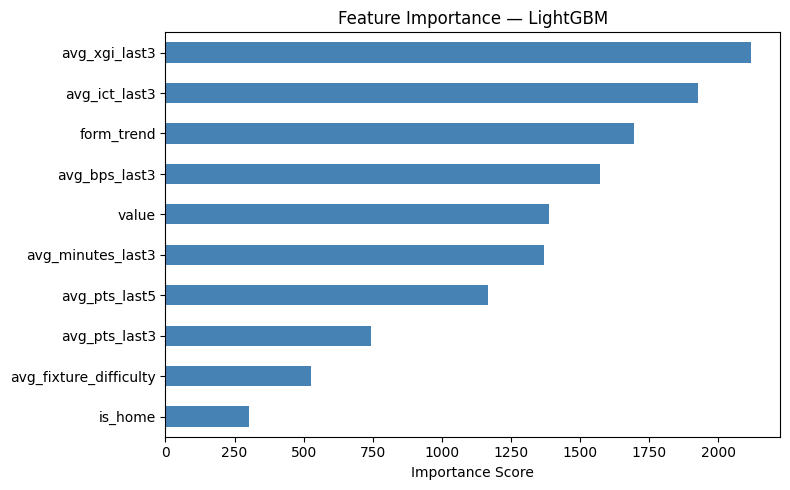

avg_xgi_last3             2117
avg_ict_last3             1927
form_trend                1693
avg_bps_last3             1573
value                     1386
avg_minutes_last3         1370
avg_pts_last5             1168
avg_pts_last3              742
avg_fixture_difficulty     527
is_home                    303
dtype: int32


In [40]:
importances = pd.Series(lgbm.feature_importances_, index=FEATURES).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
importances.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Feature Importance — LightGBM')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.savefig(DATA_DIR / 'feature_importance.png', dpi=150)
plt.show()

print(importances.sort_values(ascending=False))

### 4.4 Save Model

In [41]:
joblib.dump(lgbm, MODELS_DIR / 'fpl_model.pkl')
print(f'LightGBM model saved to {MODELS_DIR / "fpl_model.pkl"}')

LightGBM model saved to models\fpl_model.pkl


## 5. Player Predictions

Generate predicted points for the upcoming gameweek for all active players.

In [42]:
latest_gw = df_model.groupby('player_id').last().reset_index()
latest_gw = latest_gw[FEATURES + ['player_id']].dropna()
latest_gw['predicted_pts'] = lgbm.predict(latest_gw[FEATURES])

players_info = players[['id', 'web_name', 'element_type', 'now_cost', 'team']].copy()
latest_gw    = latest_gw.merge(players_info, left_on='player_id', right_on='id')

latest_gw.to_csv(DATA_DIR / 'player_predictions.csv', index=False)
print(f'Predictions saved: {len(latest_gw)} players')
print('\nTop 10 predicted players:')
print(latest_gw[['web_name','predicted_pts','now_cost']].sort_values('predicted_pts', ascending=False).head(10).to_string(index=False))

Predictions saved: 817 players

Top 10 predicted players:
   web_name  predicted_pts  now_cost
     Palmer       8.431136       106
M.Fernandes       5.087917        55
    Gabriel       5.082907        71
    Haaland       4.895970       148
       Neto       4.456825        70
      Cunha       4.377257        81
    M.Salah       4.280288       140
     Rogers       4.222524        77
    Semenyo       4.158705        80
      Wirtz       4.051236        84


## 6. Team Optimization — Integer Linear Programming

We use ILP (via PuLP) to select the optimal squad that maximises total predicted points subject to:
- Exactly 15 players in the squad (2 GK, 5 DEF, 5 MID, 3 FWD)
- Total cost ≤ £100m budget
- Maximum 3 players from any single club
- Backup GK capped at £4.0m
- Phase 2 picks the best 11 starters with valid formation (1 GK, 3-5 DEF, 3-5 MID, 1-3 FWD)

In [43]:
def optimize_squad_ilp(predictions_df, budget=1000):
    df = predictions_df.copy()
    pos_map = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    df['position'] = df['element_type'].map(pos_map)
    df = df.reset_index(drop=True)
    n = len(df)

    # ── Phase 1: Select 15-man squad ──────────────────────────────────────────
    prob = pulp.LpProblem('FPL_Squad', pulp.LpMaximize)
    x    = [pulp.LpVariable(f'x{i}', cat='Binary') for i in range(n)]

    prob += pulp.lpSum(df['predicted_pts'][i] * x[i] for i in range(n))
    prob += pulp.lpSum(x) == 15
    prob += pulp.lpSum(df['now_cost'][i] * x[i] for i in range(n)) <= budget

    for pos, mn, mx in [('GK',2,2),('DEF',5,5),('MID',5,5),('FWD',3,3)]:
        idx = df[df['position'] == pos].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) >= mn
        prob += pulp.lpSum(x[i] for i in idx) <= mx

    for team_id in df['team'].unique():
        idx = df[df['team'] == team_id].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) <= 3

    expensive_idx  = df[df['now_cost'] > 60].index.tolist()
    prob += pulp.lpSum(x[i] for i in expensive_idx) <= 10

    cheap_gk_idx = df[(df['now_cost'] <= 40) & (df['position'] == 'GK')].index.tolist()
    prob += pulp.lpSum(x[i] for i in cheap_gk_idx) >= 1

    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    squad = df[[x[i].value() == 1 for i in range(n)]].copy()

    # ── Phase 2: Pick best starting 11 ───────────────────────────────────────
    squad = squad.reset_index(drop=True)
    m     = len(squad)
    prob2 = pulp.LpProblem('FPL_Starting11', pulp.LpMaximize)
    y     = [pulp.LpVariable(f'y{i}', cat='Binary') for i in range(m)]

    prob2 += pulp.lpSum(squad['predicted_pts'][i] * y[i] for i in range(m))
    prob2 += pulp.lpSum(y) == 11

    for pos, mn, mx in [('GK',1,1),('DEF',3,5),('MID',3,5),('FWD',1,3)]:
        idx = squad[squad['position'] == pos].index.tolist()
        prob2 += pulp.lpSum(y[i] for i in idx) >= mn
        prob2 += pulp.lpSum(y[i] for i in idx) <= mx

    prob2.solve(pulp.PULP_CBC_CMD(msg=0))
    squad['is_starter'] = [y[i].value() == 1 for i in range(m)]
    return squad


full_squad = optimize_squad_ilp(latest_gw)
starters   = full_squad[full_squad['is_starter'] == True]
bench      = full_squad[full_squad['is_starter'] == False]

print(f"Total Squad Cost: £{full_squad['now_cost'].sum() / 10:.1f}m / £100m")
print(f"Predicted Points (Starting 11): {starters['predicted_pts'].sum():.2f}")
print('\n── STARTING 11 ──')
print(starters[['web_name','position','now_cost','predicted_pts']].sort_values('position').to_string(index=False))
print('\n── BENCH (4) ──')
print(bench[['web_name','position','now_cost','predicted_pts']].sort_values('position').to_string(index=False))

full_squad.to_csv(DATA_DIR / 'optimized_squad.csv', index=False)

Total Squad Cost: £99.7m / £100m
Predicted Points (Starting 11): 51.78

── STARTING 11 ──
   web_name position  now_cost  predicted_pts
    Gabriel      DEF        71       5.082907
   Truffert      DEF        45       4.024365
      Guéhi      DEF        52       3.944017
       Aina      DEF        47       3.710005
 João Pedro      FWD        77       3.931852
    Haaland      FWD       148       4.895970
   Pickford       GK        56       3.840859
     Palmer      MID       106       8.431136
       Neto      MID        70       4.456825
      Cunha      MID        81       4.377257
M.Fernandes      MID        55       5.087917

── BENCH (4) ──
   web_name position  now_cost  predicted_pts
   Reinildo      DEF        38       3.472210
  Armstrong      FWD        55       3.340718
   Dúbravka       GK        40       2.200533
Summerville      MID        56       3.579187


## 6b. Transfer-Aware Optimization

Rather than picking a squad from scratch, this section finds the **optimal set of transfers** from your current squad.

**Settings:**
- `current_squad_names` — web_name of every player in your current 15
- `free_transfers` — how many free transfers you have this week (usually 1 or 2)
- `hit_cost` — points deducted per additional transfer beyond free transfers (default 4)

The optimizer maximises `predicted_pts - transfer_hit_points` subject to all standard FPL squad rules.

In [44]:
# ── Configure your current squad and transfer budget here ────────────────────
current_squad_names = [
    # Replace these with your actual squad — use exact web_name values
    # e.g. 'Salah', 'Haaland', 'Palmer', etc.
    'Player1', 'Player2', 'Player3', 'Player4', 'Player5',
    'Player6', 'Player7', 'Player8', 'Player9', 'Player10',
    'Player11', 'Player12', 'Player13', 'Player14', 'Player15',
]

free_transfers = 1   # free transfers available this week
hit_cost       = 4   # points deducted per transfer beyond free
budget         = 1000  # total squad budget in tenths (1000 = £100m)
# ─────────────────────────────────────────────────────────────────────────────

In [45]:
def optimize_transfers(predictions_df, current_names, free_transfers=1, hit_cost=4, budget=1000):
    """
    Find the optimal transfers from the current squad.

    Parameters
    ----------
    predictions_df  : DataFrame with predicted_pts, now_cost, element_type, team, web_name
    current_names   : list of web_name strings for the 15 players in the current squad
    free_transfers  : number of free transfers available
    hit_cost        : points deducted per transfer beyond the free allocation
    budget          : total squad budget in tenths of millions (1000 = £100m)

    Returns
    -------
    new_squad : DataFrame of the recommended 15-man squad
    transfers_out : players being sold
    transfers_in  : players being bought
    net_hit       : points hit incurred (0 if within free transfers)
    """
    df       = predictions_df.copy().reset_index(drop=True)
    pos_map  = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    df['position'] = df['element_type'].map(pos_map)
    n        = len(df)

    # Flag players who are currently in the squad
    df['in_current'] = df['web_name'].isin(current_names).astype(int)
    current_cost     = df[df['in_current'] == 1]['now_cost'].sum()

    # x[i] = 1 if player i is in the NEW squad
    # t[i] = 1 if player i is transferred IN (was not in current squad)
    prob = pulp.LpProblem('FPL_Transfers', pulp.LpMaximize)
    x    = [pulp.LpVariable(f'x{i}', cat='Binary') for i in range(n)]
    t    = [pulp.LpVariable(f't{i}', cat='Binary') for i in range(n)]
    # h = number of hits (transfers beyond free allocation), continuous ≥ 0
    h    = pulp.LpVariable('hits', lowBound=0, cat='Continuous')

    # Objective: maximise predicted points minus transfer hit cost
    prob += pulp.lpSum(df['predicted_pts'][i] * x[i] for i in range(n)) - hit_cost * h

    # Squad size = 15
    prob += pulp.lpSum(x) == 15

    # Budget
    prob += pulp.lpSum(df['now_cost'][i] * x[i] for i in range(n)) <= budget

    # Position limits
    for pos, mn, mx in [('GK',2,2),('DEF',5,5),('MID',5,5),('FWD',3,3)]:
        idx = df[df['position'] == pos].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) >= mn
        prob += pulp.lpSum(x[i] for i in idx) <= mx

    # Max 3 per club
    for team_id in df['team'].unique():
        idx = df[df['team'] == team_id].index.tolist()
        prob += pulp.lpSum(x[i] for i in idx) <= 3

    # Cheap backup GK
    cheap_gk = df[(df['now_cost'] <= 40) & (df['position'] == 'GK')].index.tolist()
    prob += pulp.lpSum(x[i] for i in cheap_gk) >= 1

    # Transfer-in indicator: t[i]=1 when player is new (x=1 but was not in current squad)
    # t[i] >= x[i] - in_current[i]  →  forces t[i]=1 when x=1 and in_current=0
    for i in range(n):
        prob += t[i] >= x[i] - df['in_current'][i]
        prob += t[i] <= x[i]                        # can't transfer in if not selected
        prob += t[i] <= 1 - df['in_current'][i]     # already in squad → not a transfer-in

    # Hits = max(0, transfers_in - free_transfers)
    prob += h >= pulp.lpSum(t) - free_transfers

    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    new_squad     = df[[x[i].value() == 1 for i in range(n)]].copy()
    transfers_in  = new_squad[new_squad['in_current'] == 0]
    transfers_out_names = [name for name in current_names if name not in new_squad['web_name'].values]
    transfers_out = df[df['web_name'].isin(transfers_out_names)]
    net_hit       = max(0, int(round(h.value()))) * hit_cost

    return new_squad, transfers_in, transfers_out, net_hit


new_squad, transfers_in, transfers_out, net_hit = optimize_transfers(
    latest_gw,
    current_squad_names,
    free_transfers=free_transfers,
    hit_cost=hit_cost,
    budget=budget,
)

n_transfers = len(transfers_in)
print(f'Transfers made:  {n_transfers} ({max(0, n_transfers - free_transfers)} hit(s), -{net_hit} pts)')
print(f"New squad cost:  £{new_squad['now_cost'].sum() / 10:.1f}m")
print(f"Projected pts gain from transfers (before hit): "
      f"{transfers_in['predicted_pts'].sum() - transfers_out['predicted_pts'].sum():.2f}")

if n_transfers > 0:
    print('\n── TRANSFER OUT ──')
    print(transfers_out[['web_name','position','now_cost','predicted_pts']].to_string(index=False))
    print('\n── TRANSFER IN ──')
    print(transfers_in[['web_name','position','now_cost','predicted_pts']].to_string(index=False))
else:
    print('\nNo transfers recommended — keep your current squad.')

new_squad.to_csv(DATA_DIR / 'transfer_squad.csv', index=False)

Transfers made:  15 (14 hit(s), -56 pts)
New squad cost:  £99.7m
Projected pts gain from transfers (before hit): 64.38

── TRANSFER OUT ──
Empty DataFrame
Columns: [web_name, position, now_cost, predicted_pts]
Index: []

── TRANSFER IN ──
   web_name position  now_cost  predicted_pts
    Gabriel      DEF        71       5.082907
   Truffert      DEF        45       4.024365
     Palmer      MID       106       8.431136
       Neto      MID        70       4.456825
 João Pedro      FWD        77       3.931852
      Guéhi      DEF        52       3.944017
   Pickford       GK        56       3.840859
    Haaland      FWD       148       4.895970
      Cunha      MID        81       4.377257
   Dúbravka       GK        40       2.200533
       Aina      DEF        47       3.710005
   Reinildo      DEF        38       3.472210
Summerville      MID        56       3.579187
M.Fernandes      MID        55       5.087917
  Armstrong      FWD        55       3.340718


## 7. Validation — Predicted vs Actual

We validate the model on the last 5 gameweeks by comparing predicted points against actual points scored.

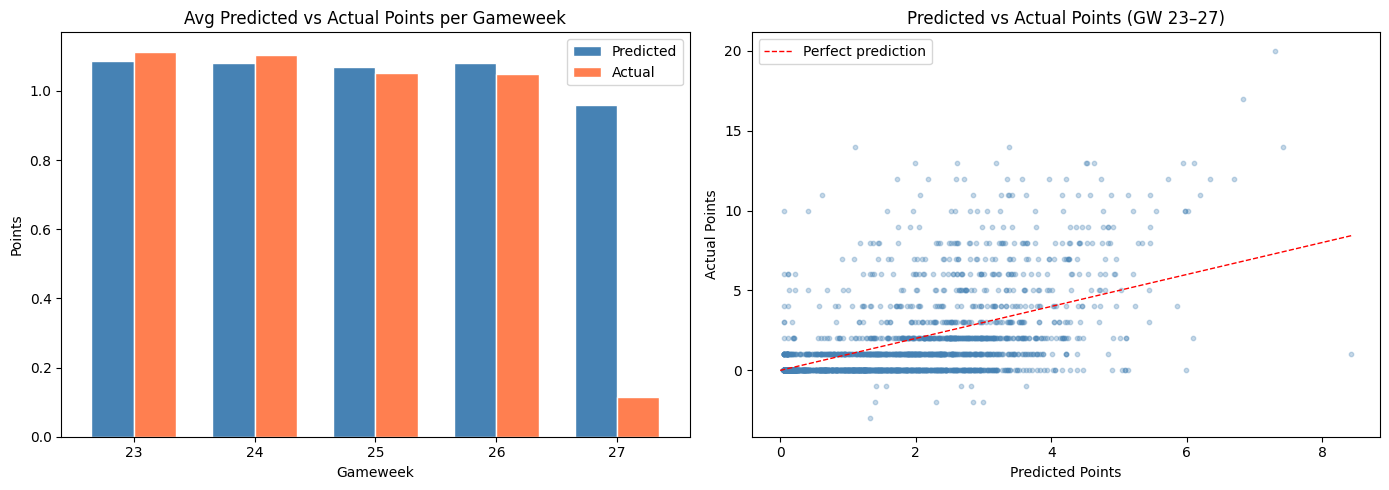

MAE per gameweek:
  GW 23: 0.939
  GW 24: 0.852
  GW 25: 0.830
  GW 26: 0.821
  GW 27: 0.889

Overall validation MAE: 0.865
Training MAE:           1.018
Baseline MAE:           1.504


In [46]:
max_gw        = int(df_model['round'].max())
validation_gws = list(range(max(1, max_gw - 4), max_gw + 1))
validation_rows = []

for gw in validation_gws:
    test_data  = df_model[df_model['round'] == gw].copy()
    test_clean = test_data[FEATURES + ['total_points', 'player_id']].dropna().copy()
    if len(test_clean) == 0:
        continue
    test_clean['predicted'] = lgbm.predict(test_clean[FEATURES])
    test_clean['actual']    = test_clean['total_points']
    test_clean['gameweek']  = gw
    validation_rows.append(test_clean[['player_id','gameweek','predicted','actual']])

val_df = pd.concat(validation_rows, ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

gw_summary = val_df.groupby('gameweek')[['predicted','actual']].mean()
gw_summary.plot(kind='bar', ax=axes[0], color=['steelblue','coral'], width=0.7, edgecolor='white')
axes[0].set_title('Avg Predicted vs Actual Points per Gameweek')
axes[0].set_xlabel('Gameweek')
axes[0].set_ylabel('Points')
axes[0].legend(['Predicted','Actual'])
axes[0].tick_params(axis='x', rotation=0)

axes[1].scatter(val_df['predicted'], val_df['actual'], alpha=0.3, color='steelblue', s=10)
axes[1].plot([0, val_df['predicted'].max()], [0, val_df['predicted'].max()], 'r--', linewidth=1, label='Perfect prediction')
axes[1].set_title(f'Predicted vs Actual Points (GW {validation_gws[0]}–{validation_gws[-1]})')
axes[1].set_xlabel('Predicted Points')
axes[1].set_ylabel('Actual Points')
axes[1].legend()

plt.tight_layout()
plt.savefig(DATA_DIR / 'validation_chart.png', dpi=150)
plt.show()

print('MAE per gameweek:')
for gw in validation_gws:
    gw_data = val_df[val_df['gameweek'] == gw]
    if len(gw_data) > 0:
        print(f'  GW {gw}: {mean_absolute_error(gw_data["actual"], gw_data["predicted"]):.3f}')

print(f'\nOverall validation MAE: {mean_absolute_error(val_df["actual"], val_df["predicted"]):.3f}')
print(f'Training MAE:           {lgbm_mae:.3f}')
print(f'Baseline MAE:           {baseline_mae:.3f}')